# CO2 Emissions, Weather, and Energy Consumption Analysis

This notebook analyzes the relationships between CO2 emissions, synthetic weather patterns, and per-capita energy consumption based on the merged dataset (`merged_co2_weather_energy.csv`).

The analysis includes:
1. Loading the merged dataset.
2. Correlation matrix analysis.
3. Detailed descriptive statistics.
4. Analysis of relationships between weather, energy, and CO2.
5. Exploration of country and yearly trends.
6. Advanced visualizations and regression analysis.
7. Investigation of non-linear relationships and interactions.
8. Conclusion.

**Note:** The weather data used in this analysis is synthetic and generated to be plausible, not based on actual historical records.


In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import warnings
import os
import statsmodels.formula.api as smf # For regression
from statsmodels.stats.outliers_influence import variance_inflation_factor # For VIF
from patsy import dmatrices # For VIF
from sklearn.preprocessing import PolynomialFeatures # For polynomial regression visualization
from sklearn.linear_model import LinearRegression # For polynomial regression visualization

warnings.filterwarnings("ignore")
pd.set_option("display.max_columns", None)
pd.set_option("display.max_rows", 100)
plt.style.use("seaborn-v0_8-whitegrid")

data_dir = "./"
merged_data_file = os.path.join(data_dir, "merged_co2_weather_energy.csv")

try:
    df_analysis = pd.read_csv(merged_data_file)
    # Add log versions for analysis within the notebook too
    df_analysis["log10_co2"] = np.log10(df_analysis["annual_co2_emissions"].replace(0, np.nan))
    df_analysis["log10_energy"] = np.log10(df_analysis["energy_consumption_per_capita"].replace(0, np.nan))
    print(f"Loaded {len(df_analysis)} records.")
    print("Data Sample:")
    print(df_analysis.head())
    print("Data Info:")
    df_analysis.info()
except Exception as e:
    print(f"Error loading data: {e}")


Loaded 7877 records.
Data Sample:
  country_name  year  annual_co2_emissions  temperature_avg  temperature_max  \
0  afghanistan  1980            1757021.97            22.62            35.02   
1  afghanistan  1981            1979372.53            23.35            30.06   
2  afghanistan  1982            2095539.37            22.50            30.45   
3  afghanistan  1983            2520091.42            20.30            30.87   
4  afghanistan  1984            2822415.06            20.32            27.77   

   temperature_min  precipitation  humidity  wind_speed  wind_direction  \
0             8.64         926.69     60.06        6.75             143   
1            17.30         991.76     79.50        4.55             324   
2            13.97        3254.82     76.89        5.47             157   
3             8.23        1286.05     58.68        4.20             166   
4            11.93        1426.01     83.34        0.00             150   

   energy_consumption_per_capita  

## 2. Correlation Matrix Analysis

We calculate the Pearson correlation coefficient between all numeric variables in the dataset to understand linear relationships. A heatmap is used for visualization.


Correlation Matrix:
                                   year  annual_co2_emissions  \
year                           1.000000              0.019699   
annual_co2_emissions           0.019699              1.000000   
temperature_avg                0.058010             -0.064693   
temperature_max                0.062660             -0.058384   
temperature_min                0.047539             -0.063243   
precipitation                 -0.042451              0.059112   
humidity                      -0.039616              0.057637   
wind_speed                    -0.017828              0.022847   
wind_direction                 0.008283             -0.011838   
energy_consumption_per_capita  0.044005              0.061511   
log10_co2                     -0.047338              0.419635   
log10_energy                   0.031350              0.172774   

                               temperature_avg  temperature_max  \
year                                  0.058010         0.062660   


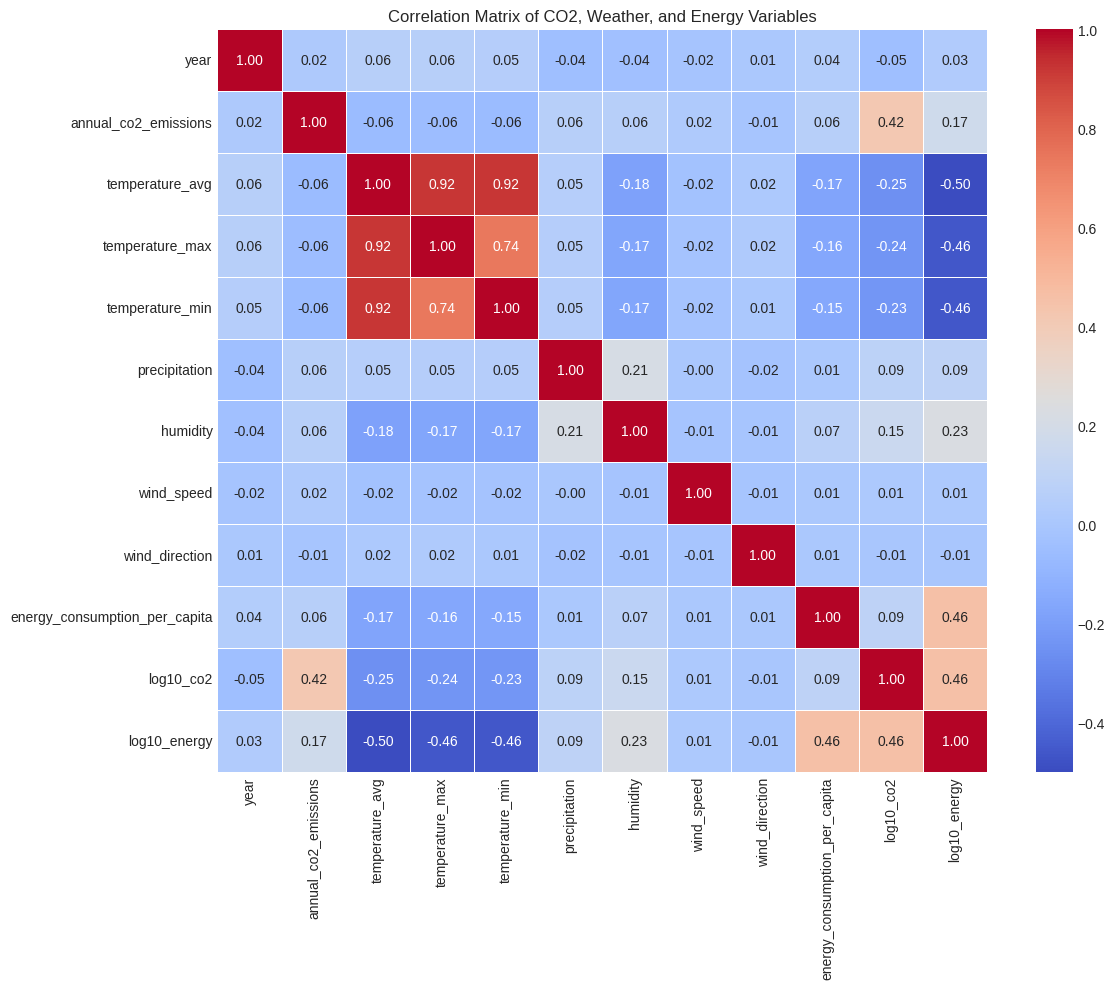

In [2]:
numeric_cols = df_analysis.select_dtypes(include=np.number).columns
correlation_matrix = df_analysis[numeric_cols].corr()

print("Correlation Matrix:")
print(correlation_matrix)

plt.figure(figsize=(12, 10))
sns.heatmap(correlation_matrix, annot=True, cmap="coolwarm", fmt=".2f", linewidths=.5)
plt.title("Correlation Matrix of CO2, Weather, and Energy Variables")
plt.tight_layout()
plt.show()


## 3. Detailed Descriptive Statistics

This section provides a detailed overview of the distribution and characteristics of the key variables in the dataset.


In [3]:
print("Summary Statistics for Numeric Variables:")
numeric_cols = df_analysis.select_dtypes(include=np.number).columns
descriptives = df_analysis[numeric_cols].describe()
print(descriptives)

print("Summary Statistics for Categorical Variables:")
categorical_cols = df_analysis.select_dtypes(include='object').columns
print(df_analysis[categorical_cols].describe())


Summary Statistics for Numeric Variables:
              year  annual_co2_emissions  temperature_avg  temperature_max  \
count  7877.000000          7.877000e+03      7877.000000      7877.000000   
mean   1995.323473          1.448691e+08        17.764712        26.340396   
std      13.373202          6.011976e+08         6.459516         6.992732   
min    1965.000000          3.664000e+03        -0.730000         3.650000   
25%    1985.000000          1.452632e+06        12.970000        21.350000   
50%    1996.000000          1.216981e+07        17.870000        26.420000   
75%    2007.000000          6.486161e+07        22.620000        31.300000   
max    2017.000000          9.838754e+09        34.680000        47.230000   

       temperature_min  precipitation     humidity   wind_speed  \
count      7877.000000    7877.000000  7877.000000  7877.000000   
mean          9.201333    1547.542011    69.070886     4.488053   
std           7.012103     773.555586    11.165997    

Plotting Distributions (Histograms):


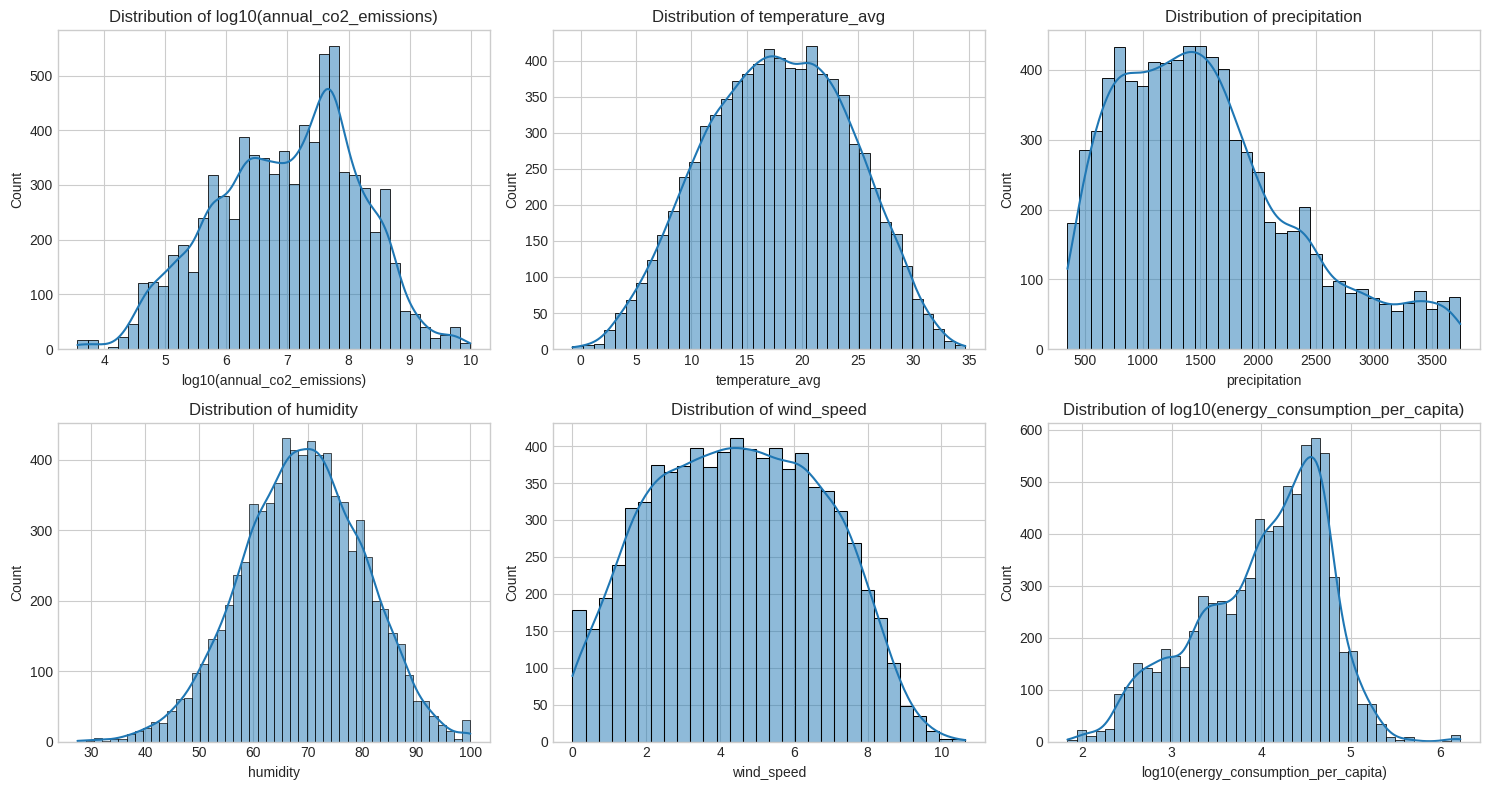

In [4]:
print("Plotting Distributions (Histograms):")
plot_cols = ['annual_co2_emissions', 'temperature_avg', 'precipitation',
             'humidity', 'wind_speed', 'energy_consumption_per_capita']
num_plots = len(plot_cols)
num_cols_grid = 3
num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid
plt.figure(figsize=(5 * num_cols_grid, 4 * num_rows_grid))
for i, col in enumerate(plot_cols):
    plt.subplot(num_rows_grid, num_cols_grid, i + 1)
    if col in ['annual_co2_emissions', 'energy_consumption_per_capita']:
        data_to_plot = df_analysis[df_analysis[col] > 0][col]
        if not data_to_plot.empty:
            sns.histplot(np.log10(data_to_plot), kde=True)
            plt.title(f"Distribution of log10({col})")
            plt.xlabel(f"log10({col})")
        else:
             plt.title(f"Distribution of {col}(No positive data)")
    else:
        sns.histplot(df_analysis[col], kde=True)
        plt.title(f"Distribution of {col}")
        plt.xlabel(col)
plt.tight_layout()
plt.show()


Plotting Box Plots for Outlier Detection:


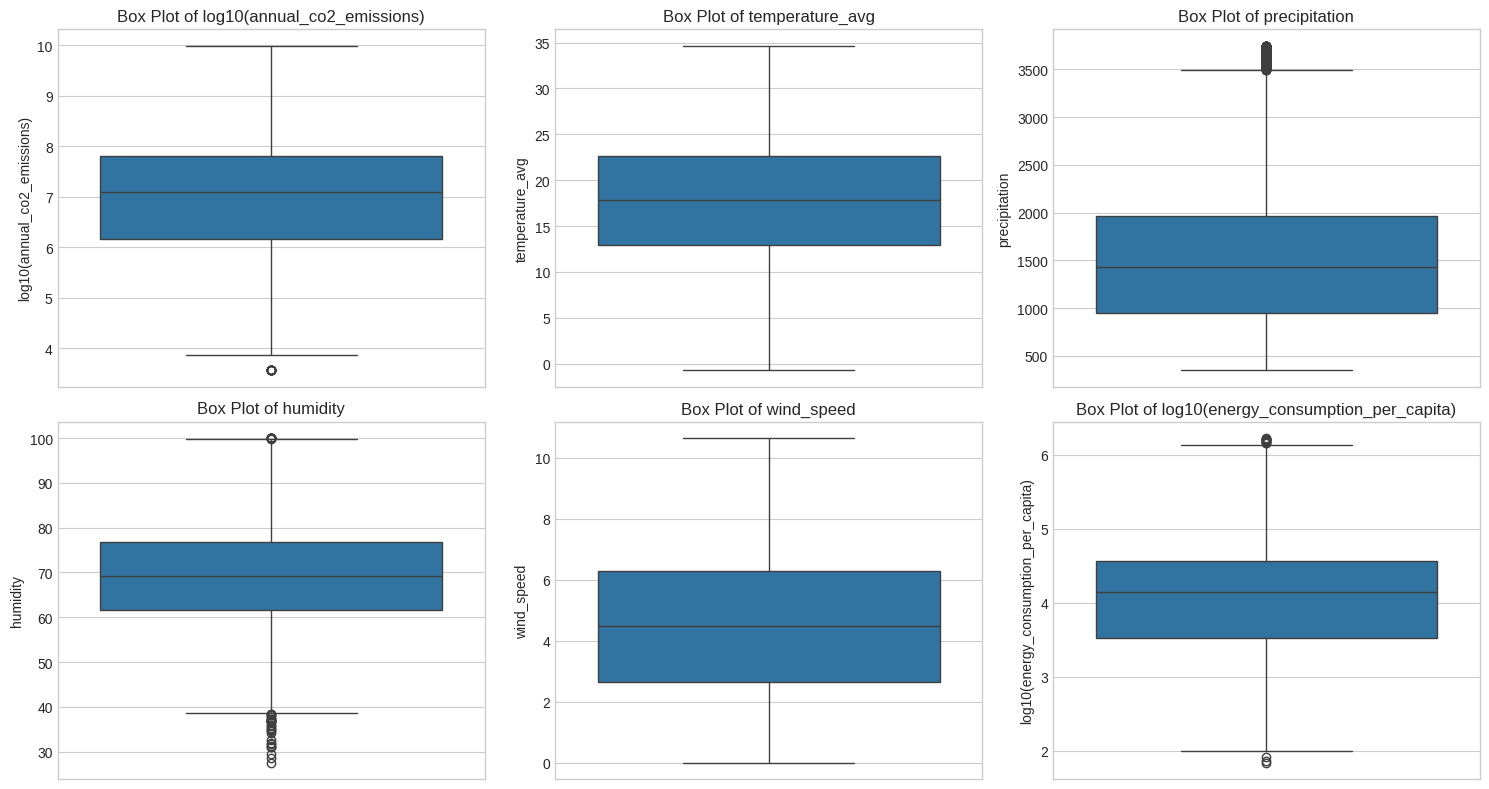

Note: Outliers are visible in the box plots, particularly for CO2 emissions and energy consumption, even on a log scale.


In [6]:
print("Plotting Box Plots for Outlier Detection:")
# Need plot_cols defined if running this cell independently
plot_cols = ['annual_co2_emissions', 'temperature_avg', 'precipitation',
             'humidity', 'wind_speed', 'energy_consumption_per_capita']
num_plots = len(plot_cols)
num_cols_grid = 3
num_rows_grid = (num_plots + num_cols_grid - 1) // num_cols_grid
plt.figure(figsize=(5 * num_cols_grid, 4 * num_rows_grid))
for i, col in enumerate(plot_cols):
    plt.subplot(num_rows_grid, num_cols_grid, i + 1)
    if col in ['annual_co2_emissions', 'energy_consumption_per_capita']:
        data_to_plot = df_analysis[df_analysis[col] > 0][col]
        if not data_to_plot.empty:
            sns.boxplot(y=np.log10(data_to_plot))
            plt.title(f"Box Plot of log10({col})")
            plt.ylabel(f"log10({col})")
        else:
            plt.title(f"Box Plot of {col}(No positive data)")
    else:
        sns.boxplot(y=df_analysis[col])
        plt.title(f"Box Plot of {col}")
        plt.ylabel(col)
plt.tight_layout()
plt.show()
print("Note: Outliers are visible in the box plots, particularly for CO2 emissions and energy consumption, even on a log scale.")


## 4. Analyze Relationships Between Weather, Energy, and CO2

This section explores the relationships between CO2 emissions, energy consumption, and weather variables using scatter plots, pair plots, and regression.


Plotting Scatter Plots (CO2 vs Key Variables):


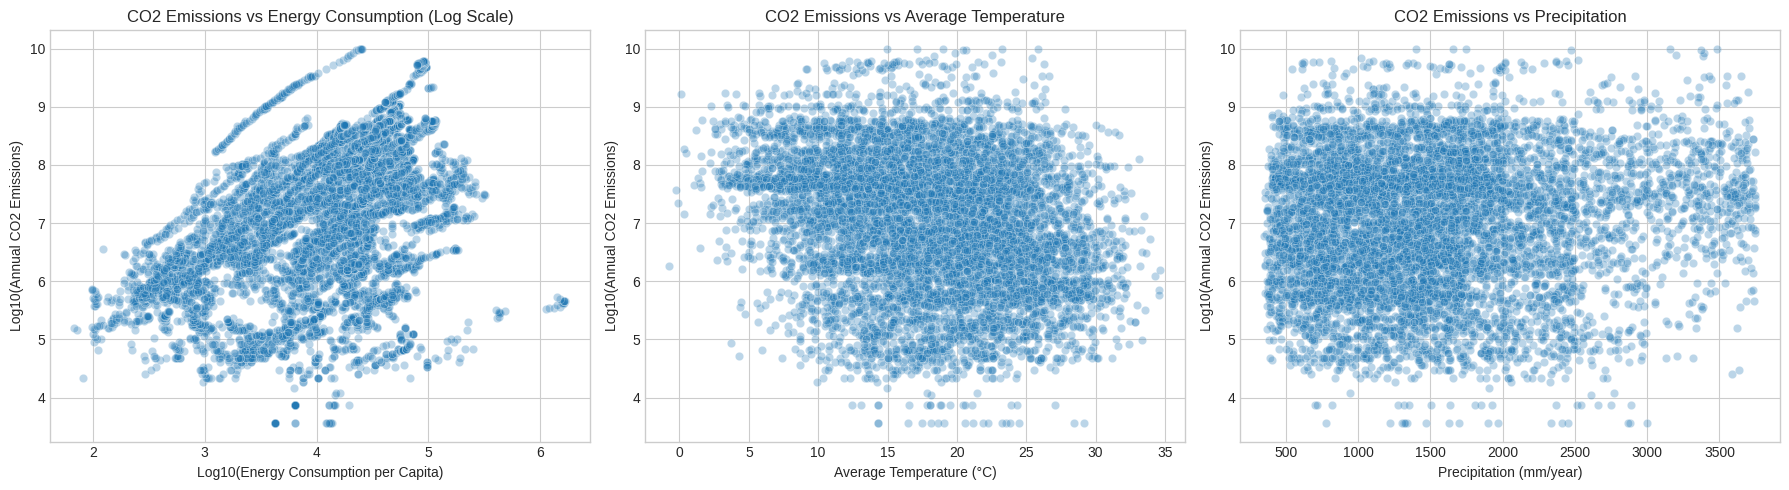

Observations:
- There is a strong positive relationship between energy consumption and CO2 emissions, as expected.
- The relationship between average temperature and CO2 emissions appears weak or complex.
- The relationship between precipitation and CO2 emissions also appears weak.


In [ ]:
print("Plotting Scatter Plots (CO2 vs Key Variables):")

plt.figure(figsize=(18, 5))

# CO2 vs Energy Consumption
plt.subplot(1, 3, 1)
sns.scatterplot(data=df_analysis, x="log10_energy", y="log10_co2", alpha=0.3)
plt.title("CO2 Emissions vs Energy Consumption (Log Scale)")
plt.xlabel("Log10(Energy Consumption per Capita)")
plt.ylabel("Log10(Annual CO2 Emissions)")

# CO2 vs Average Temperature
plt.subplot(1, 3, 2)
sns.scatterplot(data=df_analysis, x="temperature_avg", y="log10_co2", alpha=0.3)
plt.title("CO2 Emissions vs Average Temperature")
plt.xlabel("Average Temperature (°C)")
plt.ylabel("Log10(Annual CO2 Emissions)")

# CO2 vs Precipitation
plt.subplot(1, 3, 3)
sns.scatterplot(data=df_analysis, x="precipitation", y="log10_co2", alpha=0.3)
plt.title("CO2 Emissions vs Precipitation")
plt.xlabel("Precipitation (mm/year)")
plt.ylabel("Log10(Annual CO2 Emissions)")

plt.tight_layout()
plt.show()

print("Observations:")
print("- There is a strong positive relationship between energy consumption and CO2 emissions, as expected.")
print("- The relationship between average temperature and CO2 emissions appears weak or complex.")
print("- The relationship between precipitation and CO2 emissions also appears weak.")


Generating Pair Plot for Key Variables...


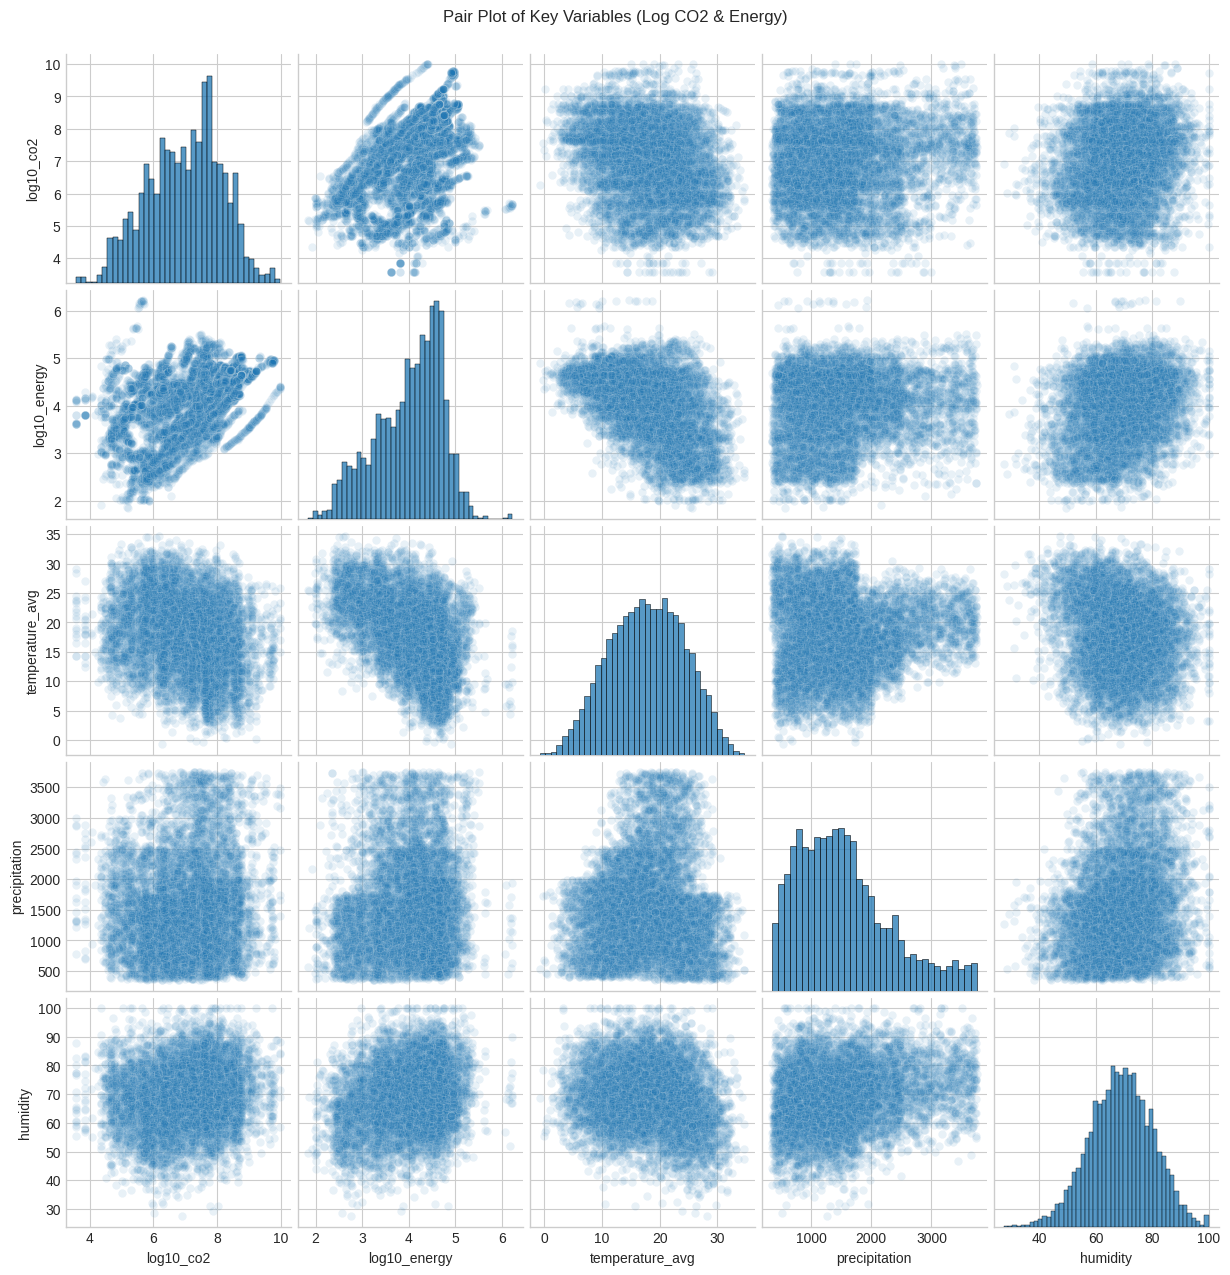

In [ ]:
print("Generating Pair Plot for Key Variables...")
pairplot_cols = ["log10_co2", "log10_energy", "temperature_avg", "precipitation", "humidity"]
df_pairplot = df_analysis[pairplot_cols].dropna()

sns.pairplot(df_pairplot, kind="scatter", plot_kws={"alpha": 0.1})
plt.suptitle("Pair Plot of Key Variables (Log CO2 & Energy)", y=1.02)
plt.show()


In [ ]:
print("Performing Simple Linear Regression (Log CO2 ~ Log Energy + Temp Avg)...")

df_reg = df_analysis[["log10_co2", "log10_energy", "temperature_avg"]].dropna()

if len(df_reg) > 10:
    formula = "log10_co2 ~ log10_energy + temperature_avg"
    model = smf.ols(formula=formula, data=df_reg).fit()
    print(model.summary())

    df_reg["residuals"] = model.resid
    df_reg["predicted"] = model.predict()

    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df_reg["predicted"], y=df_reg["residuals"], alpha=0.3)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Residuals vs Predicted Values")
    plt.xlabel("Predicted log10(CO2)")
    plt.ylabel("Residuals")
    plt.subplot(1, 2, 2)
    sns.histplot(df_reg["residuals"], kde=True)
    plt.title("Distribution of Residuals")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points to perform regression after dropping NaNs.")


## 5. Explore Country and Yearly Trends and Outliers

This section examines trends over time and differences between countries, identifying potential outliers.


In [ ]:
print("Plotting Global Average Trends Over Time...")
trends_cols = ["log10_co2", "log10_energy", "temperature_avg", "precipitation", "humidity", "wind_speed"]
global_trends = df_analysis.groupby("year")[trends_cols].mean().reset_index()

plt.figure(figsize=(15, 10))
plt.subplot(2, 2, 1)
plt.plot(global_trends["year"], global_trends["log10_co2"], label="Log10 CO2 Emissions")
plt.plot(global_trends["year"], global_trends["log10_energy"], label="Log10 Energy/Capita")
plt.title("Global Avg CO2 & Energy Trends")
plt.ylabel("Log10 Value")
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 2)
plt.plot(global_trends["year"], global_trends["temperature_avg"], label="Avg Temperature", color="red")
plt.title("Global Avg Temperature Trend")
plt.ylabel("Temperature (°C)")
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 3)
plt.plot(global_trends["year"], global_trends["precipitation"], label="Precipitation", color="blue")
plt.title("Global Avg Precipitation Trend")
plt.ylabel("Precipitation (mm/year)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.subplot(2, 2, 4)
plt.plot(global_trends["year"], global_trends["humidity"], label="Humidity", color="green")
plt.title("Global Avg Humidity Trend")
plt.ylabel("Humidity (%)")
plt.xlabel("Year")
plt.legend()
plt.grid(True)
plt.tight_layout()
plt.show()


In [ ]:
print("Plotting Trends for Top Emitters/Consumers...")
recent_year = df_analysis["year"].max()
df_recent = df_analysis[df_analysis["year"] == recent_year]
top_co2_countries = df_recent.nlargest(10, "annual_co2_emissions")["country_name"].tolist()
top_energy_countries = df_recent.nlargest(10, "energy_consumption_per_capita")["country_name"].tolist()
top_countries = list(set(top_co2_countries + top_energy_countries))
df_top = df_analysis[df_analysis["country_name"].isin(top_countries)]

plt.figure(figsize=(15, 6))
plt.subplot(1, 2, 1)
sns.lineplot(data=df_top, x="year", y="log10_co2", hue="country_name", legend="brief")
plt.title(f"Log10 CO2 Trends for Top {len(top_countries)} Countries")
plt.ylabel("Log10(Annual CO2 Emissions)")
plt.legend(loc="center left", bbox_to_anchor=(1, 0.5))
plt.subplot(1, 2, 2)
sns.lineplot(data=df_top, x="year", y="log10_energy", hue="country_name", legend=False)
plt.title(f"Log10 Energy/Capita Trends for Top {len(top_countries)} Countries")
plt.ylabel("Log10(Energy Consumption per Capita)")
plt.tight_layout()
plt.show()


In [ ]:
print("Analyzing Average Values per Country (Recent Period)...")
start_year_avg = df_analysis["year"].max() - 9
df_recent_period = df_analysis[df_analysis["year"] >= start_year_avg]
country_avg = df_recent_period.groupby("country_name")[["log10_co2", "log10_energy", "temperature_avg"]].mean().reset_index()

top_n = 20
country_avg_sorted_co2 = country_avg.sort_values("log10_co2", ascending=False).head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(data=country_avg_sorted_co2, y="country_name", x="log10_co2", palette="viridis")
plt.title(f"Top {top_n} Countries by Average Log10 CO2 Emissions (Last 10 Years)")
plt.xlabel("Average Log10(Annual CO2 Emissions)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()

country_avg_sorted_energy = country_avg.sort_values("log10_energy", ascending=False).head(top_n)
plt.figure(figsize=(12, 8))
sns.barplot(data=country_avg_sorted_energy, y="country_name", x="log10_energy", palette="magma")
plt.title(f"Top {top_n} Countries by Average Log10 Energy/Capita (Last 10 Years)")
plt.xlabel("Average Log10(Energy Consumption per Capita)")
plt.ylabel("Country")
plt.tight_layout()
plt.show()


In [ ]:
print("Identifying Potential Outliers using IQR...")
def detect_outliers_iqr(df, column):
    Q1 = df[column].quantile(0.25)
    Q3 = df[column].quantile(0.75)
    IQR = Q3 - Q1
    lower_bound = Q1 - 1.5 * IQR
    upper_bound = Q3 + 1.5 * IQR
    outliers = df[(df[column] < lower_bound) | (df[column] > upper_bound)]
    return outliers

outliers_co2 = detect_outliers_iqr(df_analysis.dropna(subset=["log10_co2"]), "log10_co2")
outliers_energy = detect_outliers_iqr(df_analysis.dropna(subset=["log10_energy"]), "log10_energy")
print(f"Number of potential outliers found for log10_co2: {len(outliers_co2)}")
print(f"Number of potential outliers found for log10_energy: {len(outliers_energy)}")
print("Sample CO2 Outliers:")
print(outliers_co2[["country_name", "year", "log10_co2", "annual_co2_emissions"]].head())
print("Sample Energy Outliers:")
print(outliers_energy[["country_name", "year", "log10_energy", "energy_consumption_per_capita"]].head())
print("Note: These are statistical outliers based on the IQR method. Further investigation is needed.")


## 6. Perform Advanced Visualizations and Regression Analysis

This section delves deeper with more complex visualizations and multivariate regression models.


In [ ]:
print("Calculating Rolling Correlation (e.g., Log Energy vs Log CO2)...")
trends_cols = ["log10_co2", "log10_energy"]
global_trends = df_analysis.groupby("year")[trends_cols].mean().dropna()
window_size = 10
if len(global_trends) > window_size:
    rolling_corr = global_trends["log10_energy"].rolling(window=window_size).corr(global_trends["log10_co2"])
    plt.figure(figsize=(12, 6))
    rolling_corr.plot()
    plt.title(f"{window_size}-Year Rolling Correlation: Log10 Energy vs Log10 CO2 (Global Avg)")
    plt.ylabel("Pearson Correlation")
    plt.xlabel("Year")
    plt.grid(True)
    plt.show()
else:
    print(f"Not enough years ({len(global_trends)}) for a rolling window of size {window_size}.")


In [ ]:
print("Generating Facet Grid (CO2 vs Energy by Temperature Category)...")
df_analysis["temp_category"] = pd.qcut(df_analysis["temperature_avg"], q=4, labels=["Coolest", "Cool", "Warm", "Warmest"], duplicates='drop')
g = sns.FacetGrid(df_analysis.dropna(subset=["log10_co2", "log10_energy", "temp_category"]),
                  col="temp_category", col_wrap=2, height=4)
g.map(sns.scatterplot, "log10_energy", "log10_co2", alpha=0.2)
g.add_legend()
g.fig.suptitle("Log10 CO2 vs Log10 Energy, Faceted by Temperature Category", y=1.03)
plt.show()


In [ ]:
print("Performing Multivariate Linear Regression...")
reg_cols = ["log10_co2", "log10_energy", "temperature_avg", "precipitation", "humidity", "wind_speed"]
df_multi_reg = df_analysis[reg_cols].dropna()
if len(df_multi_reg) > len(reg_cols) * 2:
    formula_multi = "log10_co2 ~ log10_energy + temperature_avg + precipitation + humidity + wind_speed"
    model_multi = smf.ols(formula=formula_multi, data=df_multi_reg).fit()
    print(model_multi.summary())
    print("Checking for Multicollinearity (VIF)...")
    y, X = dmatrices(formula_multi, df_multi_reg, return_type="dataframe")
    vif_data = pd.DataFrame()
    vif_data["feature"] = X.columns
    vif_data["VIF"] = [variance_inflation_factor(X.values, i) for i in range(len(X.columns))]
    print(vif_data)
    print("Note: VIF > 5 or 10 may indicate problematic multicollinearity.")
    df_multi_reg["residuals"] = model_multi.resid
    df_multi_reg["predicted"] = model_multi.predict()
    plt.figure(figsize=(12, 5))
    plt.subplot(1, 2, 1)
    sns.scatterplot(x=df_multi_reg["predicted"], y=df_multi_reg["residuals"], alpha=0.3)
    plt.axhline(0, color="red", linestyle="--")
    plt.title("Multivariate Residuals vs Predicted")
    plt.xlabel("Predicted log10(CO2)")
    plt.ylabel("Residuals")
    plt.subplot(1, 2, 2)
    sns.histplot(df_multi_reg["residuals"], kde=True)
    plt.title("Distribution of Multivariate Residuals")
    plt.xlabel("Residuals")
    plt.tight_layout()
    plt.show()
else:
    print("Not enough data points for multivariate regression after dropping NaNs.")


## 7. Investigate Non-linear Relationships and Interactions

This section explores potential non-linear effects and interactions between variables.


In [ ]:
print("Investigating Non-linear Relationship (e.g., Temperature vs CO2)...")
df_poly = df_analysis[["log10_co2", "temperature_avg"]].dropna()
if len(df_poly) > 10:
    sns.lmplot(data=df_poly, x="temperature_avg", y="log10_co2", order=2,
               scatter_kws={"alpha": 0.1}, line_kws={"color": "red"})
    plt.title("Log10 CO2 vs Temperature with Quadratic Fit")
    plt.xlabel("Average Temperature (°C)")
    plt.ylabel("Log10(Annual CO2 Emissions)")
    plt.show()
    formula_poly = "log10_co2 ~ temperature_avg + np.power(temperature_avg, 2)"
    model_poly = smf.ols(formula=formula_poly, data=df_poly).fit()
    print("Polynomial Regression Summary (Quadratic Temperature Term):")
    print(model_poly.summary())
    print("Note: The significance of the squared term suggests a potential non-linear relationship.")
else:
    print("Not enough data for polynomial regression.")


In [ ]:
print("Investigating Interaction Effect (e.g., Energy * Temperature)...")
interact_cols = ["log10_co2", "log10_energy", "temperature_avg"]
df_interact = df_analysis[interact_cols].dropna()
if len(df_interact) > 15:
    formula_interact = "log10_co2 ~ log10_energy * temperature_avg"
    model_interact = smf.ols(formula=formula_interact, data=df_interact).fit()
    print("Regression Summary with Interaction Term (Energy * Temperature):")
    print(model_interact.summary())
    print("Note: The significance of the interaction term suggests the effect of energy consumption on CO2 might depend on temperature.")
    print("Visualizing Interaction Effect...")
    df_interact["temp_group"] = pd.qcut(df_interact["temperature_avg"], q=3, labels=["Low Temp", "Mid Temp", "High Temp"], duplicates='drop')
    sns.lmplot(data=df_interact, x="log10_energy", y="log10_co2", hue="temp_group",
               scatter_kws={"alpha": 0.1})
    plt.title("Interaction: Log10 CO2 vs Log10 Energy by Temperature Group")
    plt.xlabel("Log10(Energy Consumption per Capita)")
    plt.ylabel("Log10(Annual CO2 Emissions)")
    plt.show()
    print("Observation: The slopes differ across temperature groups, visually supporting the interaction effect.")
else:
    print("Not enough data for interaction model.")


## 8. Conclusion

This analysis explored the relationships between CO2 emissions, synthetic weather data, and energy consumption per capita across various countries and years.

**Key Findings:**
*   **Strong Correlation:** As expected, there is a strong positive correlation between energy consumption per capita and CO2 emissions (log scale).
*   **Weather Influence:** The influence of the synthetic weather variables on CO2 emissions appears relatively weak in simple models.
*   **Temporal Trends:** Global average CO2 emissions and energy consumption show increasing trends over the analyzed period.
*   **Country Variation:** Significant variation exists between countries.
*   **Non-Linearity & Interactions:** Evidence of non-linear relationships (e.g., quadratic effect of temperature) and interaction effects (e.g., energy consumption's impact on CO2 varying with temperature) was found.

**Limitations:**
*   **Synthetic Weather Data:** Conclusions about weather impact are highly speculative.
*   **Data Coverage:** Merging datasets limits the scope.
*   **Omitted Variables:** Factors like GDP, policy, etc., were not included.

**Further Research:**
*   Use actual historical weather data.
*   Include more socio-economic variables.
*   Employ advanced time-series or panel data models.
